In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gmat-dataset/pems-bay.h5
/kaggle/input/gmat-dataset/SE(PeMS).txt
/kaggle/input/gmat-dataset/metr-la.h5
/kaggle/input/gmat-dataset/pems-bay/pems-bay.h5


In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW,Adam
import random
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import gc
import math
import time

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
class conv2d_(nn.Module):
    def __init__(self, input_dims, output_dims, kernel_size, stride=(1, 1),
                 padding='SAME', use_bias=True, activation=F.relu,
                 bn_decay=None):
        super(conv2d_, self).__init__()
        
        self.activation = activation
        
        if padding == 'SAME':
            self.padding_size = math.ceil(kernel_size)
        else:
            self.padding_size = [0, 0]
            
        self.conv = nn.Conv2d(input_dims, output_dims, kernel_size, stride=stride,
                              padding=0, bias=use_bias)
        
        self.batch_norm = nn.BatchNorm2d(output_dims, momentum=bn_decay)
        
        torch.nn.init.xavier_uniform_(self.conv.weight)

        if use_bias:
            torch.nn.init.zeros_(self.conv.bias)


    def forward(self, x):
        # x:(batch_size, channels, height, width)
        x = x.permute(0, 3, 2, 1) #(batch_size, height, channels, width)
        x = F.pad(x, ([self.padding_size[1], self.padding_size[1], self.padding_size[0], self.padding_size[0]]))
        x = self.conv(x)
        x = self.batch_norm(x)
        if self.activation is not None:
            x = F.relu_(x)
        return x.permute(0, 3, 2, 1)

# FC

In [5]:
class FC(nn.Module):
    def __init__(self, input_dims, units, activations, bn_decay, use_bias=True):
        super(FC, self).__init__()
        
        if isinstance(units, int):
            units = [units]
            input_dims = [input_dims]
            activations = [activations]
            
        elif isinstance(units, tuple):
            units = list(units)
            input_dims = list(input_dims)
            activations = list(activations)
            
        assert type(units) == list
        
        self.convs = nn.ModuleList([conv2d_(
            input_dims=input_dim, output_dims=num_unit, kernel_size=[1, 1], stride=[1, 1],
            padding='VALID', use_bias=use_bias, activation=activation,
            bn_decay=bn_decay) for input_dim, num_unit, activation in
            zip(input_dims, units, activations)])

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        return x

# STE

In [6]:
#FC-transform input features while keeping the spatial dimensions unchanged.



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class STEmbedding(nn.Module):
    def __init__(self, D, bn_decay):
        super(STEmbedding, self).__init__()
        self.FC_se = FC(
            input_dims=[D, D], units=[D, D], activations=[F.relu, None],
            bn_decay=bn_decay)

        # D,D is first D is input and second D is output
        self.FC_te = FC(
            input_dims=[295, D], units=[D, D], activations=[F.relu, None],
            bn_decay=bn_decay)  # input_dims = time step per day + days per week=288+7=295

    def forward(self, SE, TE, T=288):
        """
        Spatio-temporal embedding
        SE: (num_vertex, D)
        TE: (batch_size, num_his + num_pred, 2) (dayofweek, timeofday)
        T: num of time steps in one day
        D: output dims
        Return: (batch_size, num_his + num_pred, num_vertex, D)
        """
        # Spatial embedding
        SE = SE.unsqueeze(0).unsqueeze(0)  # (1, 1, num_vertex, D)
        SE = self.FC_se(SE)  # (1, 1, num_vertex, D)

        # Temporal embedding
        batch_size, num_steps, _ = TE.shape
        dayofweek = torch.empty(batch_size, num_steps, 7, device=TE.device)
        timeofday = torch.empty(batch_size, num_steps, T, device=TE.device)

        for i in range(batch_size):
            dayofweek[i] = F.one_hot(TE[..., 0][i].to(torch.int64) % 7, 7).float()

        for j in range(batch_size):
            timeofday[j] = F.one_hot(TE[..., 1][j].to(torch.int64) % 288, T).float()

        TE = torch.cat((dayofweek, timeofday), dim=-1)  # (batch_size, num_steps, 295)
        TE = TE.unsqueeze(dim=2)  # (batch_size, num_steps, 1, 295)
        TE = self.FC_te(TE)  # (batch_size, num_steps, 1, D)
        
        return SE + TE  # (batch_size, num_steps, num_vertex, D)


# SA and TA

In [8]:
class spatialAttention(nn.Module):
    def __init__(self, K, d, bn_decay):
        super(spatialAttention, self).__init__()
        
        D = K * d
        self.d = d
        self.K = K
        
        self.FC_q = FC(input_dims=2 * D, units=D, activations=F.relu,
                       bn_decay=bn_decay)
        
        self.FC_k = FC(input_dims=2 * D, units=D, activations=F.relu,
                       bn_decay=bn_decay)
        
        self.FC_v = FC(input_dims=2 * D, units=D, activations=F.relu,
                       bn_decay=bn_decay)
        
        self.FC = FC(input_dims=D, units=D, activations=F.relu,
                     bn_decay=bn_decay)

    def forward(self, X, STE):
        '''
        spatial attention mechanism
        X:(batch_size, num_step, num_vertex, D)
        STE:(batch_size, num_step, num_vertex, D)
        K:number of attention heads
        d:dimension of each attention outputs
        return: (batch_size, num_step, num_vertex, D)
        '''
        batch_size = X.shape[0] #(batch_size,num_step,num_vertices,D)
        X = torch.cat((X, STE), dim=-1) #(batch_size, num_step, num_vertex, K * d)
        
        query = self.FC_q(X)
        key = self.FC_k(X)
        value = self.FC_v(X)
        
        #(k * batch_size, num_step, num_vertices, d)
        query = torch.cat(torch.split(query, self.K, dim=-1), dim=0)
        key = torch.cat(torch.split(key, self.K, dim=-1), dim=0)
        value = torch.cat(torch.split(value, self.K, dim=-1), dim=0)

        #(batch_size,num_step,num_vertices,D) @ (batch_size,num_step,D,num_vertices)
        # ->batch_size,num_step,num_vertices,num_vertices
        attention = torch.matmul(query, key.transpose(2, 3))
        attention /= (self.d ** 0.5)
        attention = F.softmax(attention, dim=-1)
        # [batch_size, num_step, num_vertex, D]
        
        X = torch.matmul(attention, value)  #(batch_size,num_step,num_vertices,D)  #eq 7
        X = torch.cat(torch.split(X, batch_size, dim=0), dim=-1)
        X = self.FC(X)
        
        del query, key, value, attention
        return X



In [9]:
# Query=represents the current vertex’s representation. It tells the model what information is needed
# Key=represents all vertices’ representations. It tells the model what information is available
# Value =represents the actual features of the vertices that will be aggregated
# D-feature dimesnion number of features used to describe each node at time step



# Q (Query): What we are looking for
# K (Key): What information is available

# V (Value): The actual node/time step features

In [10]:
class temporalAttention(nn.Module):
    def __init__(self, K, d, bn_decay, mask=True):
        super(temporalAttention, self).__init__()
        D = K * d
        self.d = d
        self.K = K
        self.mask = mask

        # 2D- X and STE
        self.FC_q = FC(input_dims=2 * D, units=D, activations=F.relu,
                       bn_decay=bn_decay)
        
        self.FC_k = FC(input_dims=2 * D, units=D, activations=F.relu,
                       bn_decay=bn_decay)
        
        self.FC_v = FC(input_dims=2 * D, units=D, activations=F.relu,
                       bn_decay=bn_decay)
        
        self.FC = FC(input_dims=D, units=D, activations=F.relu,
                     bn_decay=bn_decay)

    def forward(self, X, STE):
        '''
        temporal attention mechanism
        X:(batch_size, num_step, num_vertex, D)
        STE:(batch_size, num_step, num_vertex, D)
        K:number of attention heads
        d:dimension of each attention outputs
        return: [batch_size, num_step, num_vertex, D)
        '''
        batch_size_ = X.shape[0]
        X = torch.cat((X, STE), dim=-1) #(batch_size, num_step, num_vertex, 2D)
        
        query = self.FC_q(X)
        key = self.FC_k(X)
        value = self.FC_v(X)
        #(batch_size, num_step, num_vertex, D)
        
        # (K*batch_size, num_step, num_vertex, d) d=D/K
        query = torch.cat(torch.split(query, self.K, dim=-1), dim=0)
        key = torch.cat(torch.split(key, self.K, dim=-1), dim=0)
        value = torch.cat(torch.split(value, self.K, dim=-1), dim=0)
        
        # query: (K * batch_size, num_vertex, num_step, d)
        # key:(K * batch_size, num_vertex, d, num_step)
        # value: (K * batch_size, num_vertex, num_step, d)
        query = query.permute(0, 2, 1, 3)
        key = key.permute(0, 2, 3, 1)
        value = value.permute(0, 2, 1, 3)
        
        #(K * batch_size, num_vertex, num_step, num_step)
        attention = torch.matmul(query, key)
        attention /= (self.d ** 0.5)
        
        if self.mask:
            batch_size = X.shape[0]
            num_step = X.shape[1]
            num_vertex = X.shape[2]
            mask = torch.ones(num_step, num_step)
            mask = torch.tril(mask)
            mask = torch.unsqueeze(torch.unsqueeze(mask, dim=0), dim=0)
            mask = mask.repeat(self.K * batch_size, num_vertex, 1, 1)
            mask = mask.to(torch.bool)
            attention = torch.where(mask, attention, -2 ** 15 + 1)
            
       
        attention = F.softmax(attention, dim=-1)
        
        X = torch.matmul(attention, value) #(K * batch_size, num_vertex, num_step, d)
        X = X.permute(0, 2, 1, 3) #(K * batch_size, num_step, num_vertex, d)
        X = torch.cat(torch.split(X, batch_size_, dim=0), dim=-1)  # orginal k to wapas le liye
        X = self.FC(X)
        del query, key, value, attention
        return X

In [11]:
class gatedFusion(nn.Module):
    def __init__(self, D, bn_decay):
        super(gatedFusion, self).__init__()
        self.FC_xs = FC(input_dims=D, units=D, activations=None,
                        bn_decay=bn_decay, use_bias=False)
        
        self.FC_xt = FC(input_dims=D, units=D, activations=None,
                        bn_decay=bn_decay, use_bias=True)
        
        self.FC_h = FC(input_dims=[D, D], units=[D, D], activations=[F.relu, None],
                       bn_decay=bn_decay)

    def forward(self, HS, HT):

        '''
        gated fusion
        HS:(batch_size, num_step, num_vertex, D)
        HT:(batch_size, num_step, num_vertex, D)
        D:output dims
        return: (batch_size, num_step, num_vertex, D)
        '''
        XS = self.FC_xs(HS)
        XT = self.FC_xt(HT)
        z = torch.sigmoid(torch.add(XS, XT))
        H = torch.add(torch.mul(z, HS), torch.mul(1 - z, HT)) #eq 11
        H = self.FC_h(H)#(batch_size,past+predict tim_step,num_vertices,D)
        del XS, XT, z
        return H

# STAtt block

In [12]:
class STAttBlock(nn.Module):
    def __init__(self, K, d, bn_decay, mask=False):
        super(STAttBlock, self).__init__()
        self.spatialAttention = spatialAttention(K, d, bn_decay)
        self.temporalAttention = temporalAttention(K, d, bn_decay, mask=mask)
        self.gatedFusion = gatedFusion(K * d, bn_decay)

    def forward(self, X, STE):
        HS = self.spatialAttention(X, STE)
        HT = self.temporalAttention(X, STE)
        H = self.gatedFusion(HS, HT)
        del HS, HT
        return torch.add(X, H)


# transform attention

In [13]:
class transformAttention(nn.Module):
    '''
    transform attention mechanism
    X:(batch_size, num_his, num_vertex, D)
    STE_his: (batch_size, num_his, num_vertex, D)
    STE_pred:(batch_size, num_pred, num_vertex, D)
    K: number of attention heads
    d: dimension of each attention outputs
    return:  (batch_size, num_pred, num_vertex, D)
    '''

    def __init__(self, K, d, bn_decay):
        super(transformAttention, self).__init__()
        D = K * d
        self.K = K
        self.d = d
        self.FC_q = FC(input_dims=D, units=D, activations=F.relu, bn_decay=bn_decay)
        self.FC_k = FC(input_dims=D, units=D, activations=F.relu, bn_decay=bn_decay)
        self.FC_v = FC(input_dims=D, units=D, activations=F.relu, bn_decay=bn_decay)
        self.FC = FC(input_dims=D, units=D, activations=F.relu, bn_decay=bn_decay)

    def forward(self, X, STE_his, STE_pred):
        batch_size = X.shape[0]
        
        # query,key,value:(batch_size, num_step, num_vertices, D)
        query = self.FC_q(STE_pred)
        key = self.FC_k(STE_his)
        value = self.FC_v(X)

        
        #(K * batch_size, num_step, num_vertex, d)
        query = torch.cat(torch.split(query, self.K, dim=-1), dim=0)
        key = torch.cat(torch.split(key, self.K, dim=-1), dim=0)
        value = torch.cat(torch.split(value, self.K, dim=-1), dim=0)

        
        # query:(K * batch_size, num_vertex, num_pred, d)
        # key:(K * batch_size, num_vertex, d, num_his)
        # value:(K * batch_size, num_vertex, num_his, d)
        query = query.permute(0, 2, 1, 3)
        key = key.permute(0, 2, 3, 1)
        value = value.permute(0, 2, 1, 3)
        
        # (K * batch_size, num_vertex, num_pred, num_his)
        attention = torch.matmul(query, key)
        attention /= (self.d ** 0.5)
        attention = F.softmax(attention, dim=-1)
        
        #(batch_size, num_pred, num_vertex, D)
        X = torch.matmul(attention, value)
        X = X.permute(0, 2, 1, 3)
        X = torch.cat(torch.split(X, batch_size, dim=0), dim=-1)
        X = self.FC(X)
        del query, key, value, attention
        return X


# model

In [14]:

class GMAN(nn.Module):
    '''
        X：(batch_size, num_his, num_vertx)
        TE：(batch_size, num_his + num_pred, 2) (time-of-day, day-of-week)
        SE：(num_vertex, K * d)
        num_his： number of history steps
        num_pred：number of prediction steps
        T：one day is divided into T steps
        L：number of STAtt blocks in the encoder/decoder
        K：number of attention heads
        d：dimension of each attention head outputs
        return：  (batch_size, num_pred, num_vertex)
    '''

    def __init__(self, L, K, d, SE, bn_decay,num_his):
        super(GMAN, self).__init__()
        L = L
        K = K
        d = d
        D = K * d
        
        self.num_his = num_his
        self.SE = SE
        self.STEmbedding = STEmbedding(D, bn_decay)
        self.STAttBlock_1 = nn.ModuleList([STAttBlock(K, d, bn_decay) for _ in range(L)])
        self.STAttBlock_2 = nn.ModuleList([STAttBlock(K, d, bn_decay) for _ in range(L)])
        self.transformAttention = transformAttention(K, d, bn_decay)
        self.FC_1 = FC(input_dims=[1, D], units=[D, D], activations=[F.relu, None], bn_decay=bn_decay)
        self.FC_2 = FC(input_dims=[D, D], units=[D, 1], activations=[F.relu, None], bn_decay=bn_decay)

    def forward(self, X, TE):

        # input
        X = torch.unsqueeze(X, -1) #(batch_size, num_his, num_vertex, 1)
        X = self.FC_1(X) #(batch_size, num_his, num_vertex, D)
        
        # STE
        STE = self.STEmbedding(self.SE.to(device), TE.to(device))
        # STE = self.STEmbedding(self.SE, TE)#(batch_size, num_his + num_pred, num_vertex, D)
        STE_his = STE[:, :self.num_his]
        STE_pred = STE[:, self.num_his:]
        
        # encoder
        for net in self.STAttBlock_1:
            X = net(X, STE_his)
            
        # transAtt
        X = self.transformAttention(X, STE_his, STE_pred) # (batch_size, num_pred, num_vertex, D)
        
        # decoder
        for net in self.STAttBlock_2:
            X = net(X, STE_pred)
            
        X = self.FC_2(X) #(batch_size, num_pred, num_vertex, 1)
        del STE, STE_his, STE_pred
        return torch.squeeze(X, 3)  #(batch_size, num_pred, num_vertex)


In [15]:
# pip install tables

# data

In [16]:
batch_size = 16
num_his = 12
num_pred = 12

L = 3
K = 8
d = 8
D = d * K

train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

patience = 10
learning_rate = 0.001
decay_epoch = 10

T = 24 * 60


In [17]:
def metric(pred, label):
    mask = torch.ne(label, 0)#not equal
    mask = mask.type(torch.float32)
    
    mask /= torch.mean(mask)
    mae = torch.abs(torch.sub(pred, label)).type(torch.float32)
    
    rmse = mae ** 2
    mape = mae / label
    mae = torch.mean(mae)
    
    rmse = rmse * mask#apply mask
    rmse = torch.sqrt(torch.mean(rmse))
    
    mape = mape * mask#apply mask
    mape = torch.mean(mape)
    return mae, rmse, mape




In [18]:

def seq2instance(data, num_his, num_pred):
    num_step, dims = data.shape # 50000,325
    num_sample = num_step - num_his - num_pred + 1#49986
    x = torch.zeros(num_sample, num_his, dims) # Shape: (49986, 12, 325)
    y = torch.zeros(num_sample, num_pred, dims) # Shape: (49986, 12, 325)
    for i in range(num_sample):
        x[i] = data[i: i + num_his]
        y[i] = data[i + num_his: i + num_his + num_pred]
    return x, y

# data read

In [19]:
df = pd.read_hdf("/kaggle/input/gmat-dataset/pems-bay.h5")

df = df[:20000]
traffic = torch.from_numpy(df.values)
print("data shape:{traffic.shape}")

# train/val/test
num_step = df.shape[0]
train_steps = round(0.7 * num_step)
test_steps = round(0.2 * num_step)
val_steps = num_step - train_steps - test_steps

train = traffic[: train_steps]
val = traffic[train_steps: train_steps + val_steps]
test = traffic[-test_steps:]

# X, Y
trainX, trainY = seq2instance(train, num_his, num_pred)
valX, valY = seq2instance(val, num_his, num_pred)
testX, testY = seq2instance(test, num_his, num_pred)

# normalization
mean, std = torch.mean(trainX), torch.std(trainX)
trainX = (trainX - mean) / std
valX = (valX - mean) / std
testX = (testX - mean) / std



data shape:{traffic.shape}


In [20]:
print(f"train_steps:{train_steps}")
print(f"test_steps:{test_steps}")
print(f"val_nsteps:{val_steps}")

train_steps:14000
test_steps:4000
val_nsteps:2000


In [21]:
print(f"trainX,trainY: {trainX.shape}, {trainY.shape}")
print(f"valX,valY:      {valX.shape}, {valY.shape}")
print(f"testX,testY:    {testX.shape}, {testY.shape}")

trainX,trainY: torch.Size([13977, 12, 325]), torch.Size([13977, 12, 325])
valX,valY:      torch.Size([1977, 12, 325]), torch.Size([1977, 12, 325])
testX,testY:    torch.Size([3977, 12, 325]), torch.Size([3977, 12, 325])


# Temporary Embedding

In [22]:
def temporal_embedding(df, num_his, num_pred):
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected a Pandas DataFrame but got another type.")

    dayofweek = np.array(df.index.weekday).reshape(-1, 1)
    timeofday = np.array((df.index.hour * 3600 + df.index.minute * 60) // 300).reshape(-1, 1)  

    Time = np.concatenate((dayofweek, timeofday), axis=-1)

    trainTE = np.zeros((train_steps - num_his - num_pred + 1, num_his + num_pred, 2), dtype=np.int32)
    valTE = np.zeros((val_steps - num_his - num_pred + 1, num_his + num_pred, 2), dtype=np.int32)
    testTE = np.zeros((test_steps - num_his - num_pred + 1, num_his + num_pred, 2), dtype=np.int32)

    for i in range(trainTE.shape[0]):
        trainTE[i] = Time[i: i + num_his + num_pred]

    for i in range(valTE.shape[0]):
        valTE[i] = Time[train_steps + i: train_steps + i + num_his + num_pred]

    for i in range(testTE.shape[0]):
        testTE[i] = Time[train_steps + val_steps + i: train_steps + val_steps + i + num_his + num_pred]

    return torch.tensor(trainTE, dtype=torch.int32), torch.tensor(valTE, dtype=torch.int32), torch.tensor(testTE, dtype=torch.int32)



# Spatial Embedding

In [23]:
def load_spatial_embedding(se_file):
    # feature dimesnion
    with open("/kaggle/input/gmat-dataset/SE(PeMS).txt", mode='r') as f:
        lines = f.readlines()
        temp = lines[0].split(' ')
        num_vertex, dims = int(temp[0]), int(temp[1])
        SE = torch.zeros((num_vertex, dims), dtype=torch.float32)
        for line in lines[1:]:
            temp = line.split(' ')
            index = int(temp[0])
            SE[index] = torch.tensor([float(ch) for ch in temp[1:]])


    return SE


# Dataset

In [24]:
class dataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y
        self.len = data_x.shape[0]

    def __getitem__(self, index):
        return self.data_x[index], self.data_y[index]

    def __len__(self):
        return self.len

In [25]:
def mae_loss(pred, label):
    mask = torch.ne(label, 0)
    mask = mask.type(torch.float32)
    mask /= torch.mean(mask)
    mask = torch.where(torch.isnan(mask), torch.tensor(0.0), mask)
    loss = torch.abs(torch.sub(pred, label))
    loss *= mask
    loss = torch.where(torch.isnan(loss), torch.tensor(0.0), loss)
    loss = torch.mean(loss)
    return loss




In [26]:

def plot_train_val_loss(train_total_loss, val_total_loss, file_path):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_total_loss) + 1), train_total_loss, c='b', marker='s', label='Train')
    plt.plot(range(1, len(val_total_loss) + 1), val_total_loss, c='r', marker='o', label='Validation')
    plt.legend(loc='best')
    plt.title('Train loss vs Validation loss')
    plt.savefig(file_path)

In [27]:
SE = load_spatial_embedding("/kaggle/input/gmat-dataset/SE(PeMS).txt")
trainTE,valTE,testTE = temporal_embedding(df,num_his,num_pred)

# model initialize

In [28]:
model = GMAN(L=L, K=K, d=d, SE=SE, bn_decay=0.1,num_his=num_his)

In [29]:
loss_criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=decay_epoch,
                                      gamma=0.9)

In [30]:
print(trainX.shape[0])

13977


In [31]:
 math.ceil(trainX.shape[0] / batch_size)

874

In [32]:
train_dataset = TensorDataset(trainX, trainTE, trainY)
val_dataset = TensorDataset(valX, valTE, valY)
test_dataset = TensorDataset(testX, testTE, testY)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
val_total_loss = []

def train_and_evaluate_epoch(model, train_loader, val_loader, optimizer, loss_criterion, scheduler, std, mean):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Train
    model.train()
    train_loss = 0.0
    print("Started Training..................")
    
    for batch_idx, (X, TE, label) in enumerate(train_loader):
        X, TE, label = X.to(device), TE.to(device), label.to(device)
        
        optimizer.zero_grad()
        pred = model(X, TE).to(device)
        pred = pred * std + mean  # Denormalize
        
        loss = loss_criterion(pred, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X.size(0)
        
        # if batch_idx % 5 == 0:
        #     print(f'Train Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        del X, TE, label, pred
    
    train_loss /= len(train_loader.dataset)
    
    # Val
    model.eval()
    val_loss = 0.0
    print("\nStarted Validation..................")
    
    with torch.no_grad():
        for batch_idx, (X, TE, label) in enumerate(val_loader):
            X, TE, label = X.to(device), TE.to(device), label.to(device)
            
            pred = model(X, TE).to(device)
            pred = pred * std + mean  # Denormalize
            loss = loss_criterion(pred, label)
            
            val_loss += loss.item() * X.size(0)
            
            # if batch_idx % 5 == 0:
            #     print(f'Val Batch: {batch_idx+1}/{len(val_loader)}, Loss: {loss.item():.4f}')
            
            del X, TE, label, pred 
    
    val_loss /= len(val_loader.dataset)
    val_total_loss.append(val_loss)
    
    # print(f"\nEpoch Summary:")
    # print(f"Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")
    
    scheduler.step()
    
    return train_loss, val_loss

In [34]:
from torch.utils.data import TensorDataset, DataLoader

def evaluate_test(model, testX, testTE, testY, batch_size, std, mean, metric, device):
   
    model.eval()
    # dataset = TensorDataset(testX, testTE, testY)
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for X_batch, TE_batch, label_batch in test_loader:
           
            X_batch = X_batch.to(device)
            TE_batch = TE_batch.to(device)
            label_batch = label_batch.to(device)
            
            pred_batch = model(X_batch, TE_batch)
            pred_batch = pred_batch * std + mean
            
            test_preds.append(pred_batch.cpu())
            test_labels.append(label_batch.cpu())
    
    # Concatenate all batches
    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)
    
    # Calculate metrics
    mae, rmse, mape = metric(test_preds, test_labels)
    return mae, rmse, mape

In [35]:
def test_model(model, trainX, trainTE, trainY, valX, valTE, valY, 
               testX, testTE, testY, batch_size, std, mean, metric, num_pred):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Create datasets
    train_dataset = TensorDataset(trainX, trainTE, trainY)
    val_dataset = TensorDataset(valX, valTE, valY)
    test_dataset = TensorDataset(testX, testTE, testY)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print("Started Testing.......................................")
    
    def check(loader):
        predictions = []
        with torch.no_grad():
            for X, TE, _ in loader:
                X, TE = X.to(device), TE.to(device)
                pred = model(X, TE).to(device)
                predictions.append(pred.cpu())
                del X, TE, pred  
                torch.cuda.empty_cache()  
        return torch.cat(predictions, dim=0) * std + mean
    
   
    print("Started train predictions...")
    trainPred = check(train_loader)
    
    print("Started validation predictions...")
    valPred = check(val_loader)
    print("Started test predictions...")
    start_test = time.time()
    testPred = check(test_loader)
    end_test = time.time()
    
    # Calculate metrics
    train_mae, train_rmse, train_mape = metric(trainPred, trainY)
    val_mae, val_rmse, val_mape = metric(valPred, valY)
    test_mae, test_rmse, test_mape = metric(testPred, testY)
    
    print(f'\nTesting Time: {end_test - start_test:.1f}s')
    print(f'Train -> MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}, MAPE: {train_mape * 100:.2f}%')
    print(f'Val   -> MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}, MAPE: {val_mape * 100:.2f}%')
    print(f'Test  -> MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, MAPE: {test_mape * 100:.2f}%')
    
    # Per-step metrics
    result = []
    MAE, RMSE, MAPE = [], [], []
    print("\nCalculating step-wise metrics...")
    for step in range(num_pred):
        mae, rmse, mape = metric(testPred[:, step], testY[:, step])
        MAE.append(mae)
        RMSE.append(rmse)
        MAPE.append(mape)
        print(f"Step {step+1}/{num_pred} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape*100:.2f}%")
    
    avg_mae = np.mean(MAE)
    avg_rmse = np.mean(RMSE)
    avg_mape = np.mean(MAPE)
    result = [MAE, RMSE, MAPE]
    
    print(f'\nAverage Metrics -> MAE: {avg_mae:.2f}, RMSE: {avg_rmse:.2f}, MAPE: {avg_mape*100:.2f}%')
    
    return testPred, testY, test_mae, test_rmse, test_mape, avg_mae, avg_rmse, avg_mape

# Trainning and Testing

In [36]:
val_losses, test_maes, test_rmses, test_mapes, train_losses =[], [], [], [], []
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    
    train_loss, val_loss = train_and_evaluate_epoch(
        model, train_loader, val_loader, optimizer, loss_criterion, scheduler, std, mean
    )
    
    test_mae, test_rmse, test_mape = evaluate_test(
        model, testX, testTE, testY, batch_size, std, mean, metric, device
    )
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_maes.append(test_mae)
    test_rmses.append(test_rmse)
    test_mapes.append(test_mape)
    
    print(f"Epoch {epoch}: Train: {train_loss:.4f}, Val: {val_loss:.4f}, "
          f"Test MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, MAPE: {test_mape*100:.2f}%")
    torch.cuda.empty_cache()



Started Training..................

Started Validation..................
Epoch 1: Train: 26.5413, Val: 17.4155, Test MAE: 2.43, RMSE: 4.76, MAPE: 5.84%
Started Training..................

Started Validation..................
Epoch 2: Train: 19.3183, Val: 14.3707, Test MAE: 2.22, RMSE: 4.44, MAPE: 5.44%
Started Training..................

Started Validation..................
Epoch 3: Train: 17.3789, Val: 13.6313, Test MAE: 2.10, RMSE: 4.15, MAPE: 4.66%
Started Training..................

Started Validation..................
Epoch 4: Train: 16.0254, Val: 14.7542, Test MAE: 2.13, RMSE: 4.19, MAPE: 4.66%
Started Training..................

Started Validation..................
Epoch 5: Train: 15.9508, Val: 13.2284, Test MAE: 2.04, RMSE: 4.07, MAPE: 4.63%
Started Training..................

Started Validation..................
Epoch 6: Train: 15.2810, Val: 12.5996, Test MAE: 2.08, RMSE: 4.14, MAPE: 4.88%
Started Training..................

Started Validation..................
Epoch 7: Train:

In [37]:

testPred, testY, test_mae, test_rmse, test_mape, avg_mae, avg_rmse, avg_mape = test_model(
    model, trainX, trainTE, trainY, valX, valTE, valY, 
    testX, testTE, testY, batch_size, std, mean, metric, num_pred
)
print(f'Final Test -> MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, MAPE: {test_mape * 100:.2f}%')

Started Testing.......................................
Started train predictions...
Started validation predictions...
Started test predictions...

Testing Time: 52.6s
Train -> MAE: 1.52, RMSE: 2.86, MAPE: 3.15%
Val   -> MAE: 1.79, RMSE: 3.79, MAPE: 3.73%
Test  -> MAE: 2.02, RMSE: 4.13, MAPE: 4.57%

Calculating step-wise metrics...
Step 1/12 -> MAE: 1.42, RMSE: 2.59, MAPE: 3.01%
Step 2/12 -> MAE: 1.59, RMSE: 3.01, MAPE: 3.43%
Step 3/12 -> MAE: 1.74, RMSE: 3.40, MAPE: 3.81%
Step 4/12 -> MAE: 1.86, RMSE: 3.72, MAPE: 4.14%
Step 5/12 -> MAE: 1.97, RMSE: 3.98, MAPE: 4.42%
Step 6/12 -> MAE: 2.05, RMSE: 4.19, MAPE: 4.66%
Step 7/12 -> MAE: 2.13, RMSE: 4.36, MAPE: 4.86%
Step 8/12 -> MAE: 2.20, RMSE: 4.50, MAPE: 5.04%
Step 9/12 -> MAE: 2.26, RMSE: 4.62, MAPE: 5.19%
Step 10/12 -> MAE: 2.31, RMSE: 4.71, MAPE: 5.32%
Step 11/12 -> MAE: 2.36, RMSE: 4.80, MAPE: 5.44%
Step 12/12 -> MAE: 2.40, RMSE: 4.87, MAPE: 5.56%

Average Metrics -> MAE: 2.02, RMSE: 4.06, MAPE: 4.57%
Final Test -> MAE: 2.02, RMSE: 4.

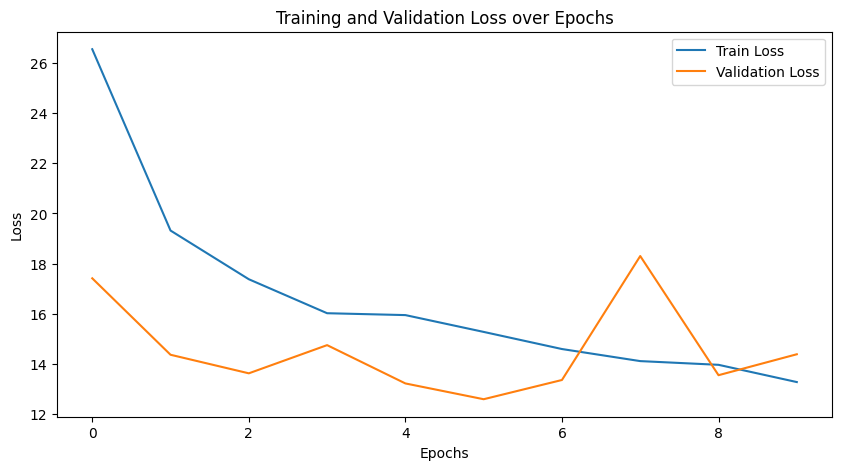

In [38]:

# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()



In [39]:
print(testY[:, :,1].shape)

torch.Size([3977, 12])


# Prediction vs actual

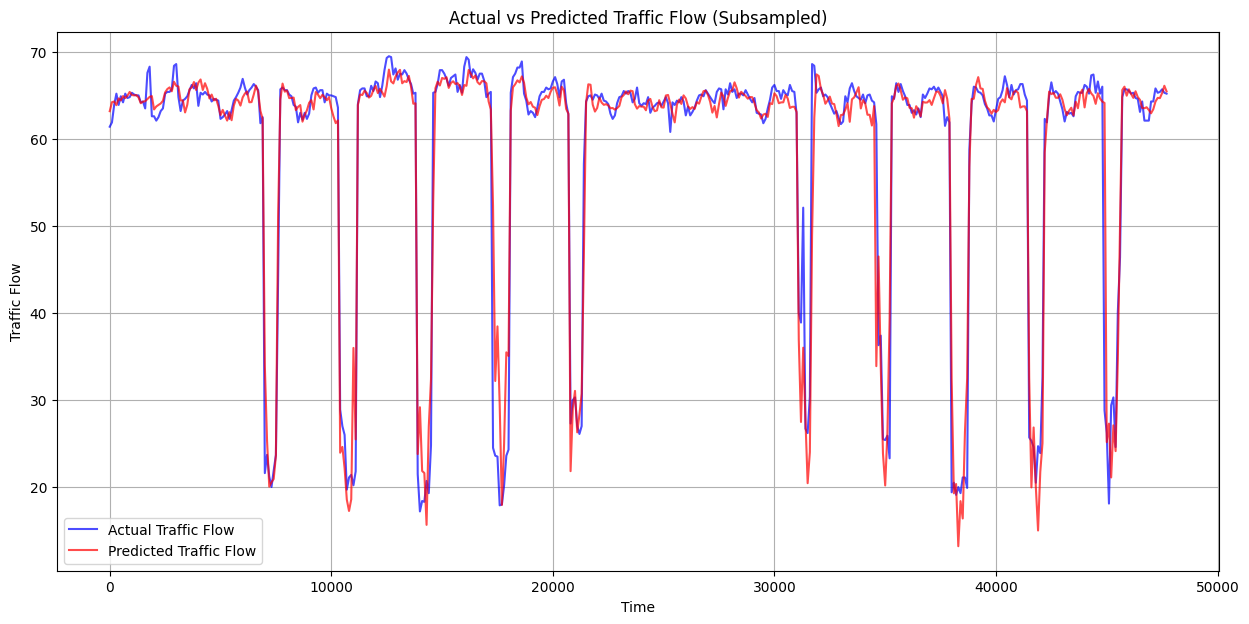

In [40]:

subsample_factor = 100  
time_steps = np.arange(0, testY[:, :, 1].numpy().flatten().shape[0], subsample_factor)
actual_subsampled = testY[:, :, 1].numpy().flatten()[::subsample_factor]
predicted_subsampled = testPred[:, :, 1].numpy().flatten()[::subsample_factor]

plt.figure(figsize=(15, 7))
plt.plot(time_steps, actual_subsampled, label='Actual Traffic Flow', color='blue', alpha=0.7, linewidth=1.5)
plt.plot(time_steps, predicted_subsampled, label='Predicted Traffic Flow', color='red', alpha=0.7, linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.legend()
plt.title('Actual vs Predicted Traffic Flow (Subsampled)')
plt.grid() 
plt.show()